Please enter the ticker for the US equity you are interested in: AAPL

Please enter the start year you would like for AAPL: 2000

Please enter the month (1-12) you want to start in for AAPL: 4

Please enter the end year you would like for AAPL: 2020

Please enter the month (1-12) you want to end in for AAPL: 4
[*********************100%***********************]  1 of 1 completed



-----------------------------------------------------------------------------
                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.276
Model:                            OLS   Adj. R-squared:                  0.273
Method:                 Least Squares   F-statistic:                     90.63
Date:                Tue, 23 Aug 2022   Prob (F-statistic):           2.05e-18
Time:                        13:06:11   Log-Likelihood:                 214.93
No. Observations:                 240   AIC:                    

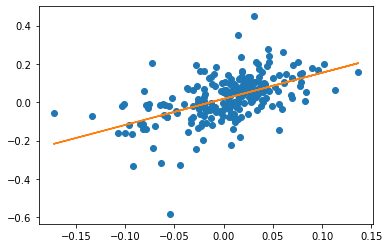

In [2]:
#Import all necessary packages
import yfinance as yf
import pandas as pd
import pendulum
from datetime import datetime
import matplotlib.pyplot as plt
import numpy as np
import statsmodels.formula.api as smf
import warnings
import scipy
warnings.filterwarnings("ignore")

#Read in the market and risk-free information from the excel provided for this assignment
market_info = pd.read_excel('HW3 Returns.xlsx')
market_df = pd.DataFrame(market_info)
market_df.rename(columns = {'Date (SAS). Last Trading Day of the Month':'Last Trading Day'}, inplace = True)


#Function to validate the users inpue to get a string only consisting of letters
def Get_User_Equity():
    User_input = -1
    while User_input == -1:
        User_input = str(input("Please enter the ticker for the US equity you are interested in: "))
        if User_input == '':
            print()
            print("Please enter a valid US equity ticker")
            User_input = -1   
        elif User_input.isalpha() == False:
            print()
            print("Please enter a valid US equity ticker")
            User_input = -1
        
    User_input = User_input.upper()
    return User_input

#Function to validate the users start input
def Get_User_Start():
    User_year = -1
    while User_year == -1:
        print()
        User_year = input("Please enter the start year you would like for " + User_input + ': ')
        if User_year == '':
            print()
            print("Please enter a valid year")
            User_year = -1
        elif User_year.isdigit() == False:
            print()
            print("Please enter a valid year")
            User_year = -1
        elif int(User_year) < 1999 or int(User_year) > 2022:
            print()
            print("Date out of range for database, please enter a valid year")
            User_year = -1
    User_year = int(User_year)
    
    User_month = -1
    while User_month == -1:
        print()
        User_month = input("Please enter the month (1-12) you want to start in for "+ User_input + ': ')
        if User_month == '':
            print()
            print('Please enter a valid month')
            User_month = -1
        elif User_month.isdigit() == False:
            print()
            print("Please enter a valid month")
        elif User_year == 2022 and int(User_month) > 6:
            print()
            print("Date out of range for database, please enter a month from January - June")
            User_month = -1
    User_month = int(User_month)
    return User_year, User_month

#Function to validate the users end input
def Get_User_End():
    User_year = -1
    while User_year == -1:
        print()
        User_year = input("Please enter the end year you would like for " + User_input + ': ')
        if User_year == '':
            print()
            print("Please enter a valid year")
            User_year = -1
        elif User_year.isdigit() == False:
            print()
            print("Please enter a valid year")
            User_year = -1
        elif int(User_year) < 1999 or int(User_year) > 2022:
            print()
            print("Date out of range for database, please enter a valid year")
            User_year = -1
    User_year = int(User_year)
    
    User_month = -1
    while User_month == -1:
        print()
        User_month = input("Please enter the month (1-12) you want to end in for "+ User_input + ': ')
        if User_month == '':
            print()
            print('Please enter a valid month')
            User_month = -1
        elif User_month.isdigit() == False:
            print()
            print("Please enter a valid month")
        elif User_year == 2022 and int(User_month) > 6:
            print()
            print("Date out of range for database, please enter a month from January - June")
            User_month = -1
    User_month = int(User_month) + 1
    return User_year, User_month

#Call the Get_User_Input function to find out which US equity the client is interested in
#Loops through until price_history is not 0
#price_history is 0 if a ticker is not found or you go backwards in time
price_history = ''
while len(price_history) == 0:
    
    User_input = Get_User_Equity()
    Start_year, Start_month = Get_User_Start()
    End_year, End_month = Get_User_End()

    price_history = yf.download(User_input,start = datetime(Start_year, Start_month, 1),end = datetime(End_year,End_month, 1) , interval = '1d')
    

#Turn price history results into DF
df = pd.DataFrame(price_history)

#Get a date index to compare to the returns df given in assignment
df['Date'] = df.index

#Grab all instances in which the returns generated equal the last trading day
#We grab last trading day per month because this is what we have our market data and rf for
mask = df['Date'].isin(market_df['Last Trading Day'])

#Create a new df of all instances that contain the last trading day of the month in the users inputted timespan
df2 = df[mask]

#This gets us the percent change of our monthly returns
df2['Monthly Return'] = df2['Adj Close'].pct_change()

#Drop all columns that are not needed
df2.drop(columns = ['Open','High','Low','Close','Adj Close','Volume'], inplace=True, axis=1)

#Index by number instead of date
index_values = []

for i in range(len(df2)):
    index_values.append(i)

df2['Numbers'] = index_values

df2.set_index('Numbers',inplace = True)


#Create a new df that only has instances of the last trading day of the month
new_df = df2.merge(market_df, left_on='Date', right_on='Last Trading Day')
new_df.drop(columns = ['Last Trading Day'], inplace = True, axis = 1)

#Run the regression of the monthly return of the user selected stock vs. the given monthly market data from the excel
y = new_df['Monthly Return']
x = new_df['Return on Market']
regression = smf.ols(formula = 'y ~ x', data = new_df).fit()
print()
print()
print()
print('-----------------------------------------------------------------------------')
print(regression.summary())

alpha = regression.params[0]
beta = regression.params[1]

alpha = regression.params[0]
beta = regression.params[1]

#Alpha statistics
#alpha P-value
# if > 0.05 so we fail to reject the null
p_value_alpha = regression.pvalues[0]
alpha_lower_confint = regression.conf_int()[0][0]
alpha_upper_confint = regression.conf_int()[0][1]
alpha_t_value = regression.tvalues[0]

#Beta Statistics

#Testing the beta with a null of 1
beta_standard_error = regression.bse[1]
beta_t_value = (beta - 1)/beta_standard_error
beta_df = regression.df_resid
beta_p_value = scipy.stats.t.sf(abs(beta_t_value), df = beta_df)
print()
print()
print()
print('The p_value of beta when our null is 1 is: ',beta_p_value)

if beta_p_value < 0.05:
    print()
    print('Since the p_value is less than 0.05 we can reject the null of beta = 1')

#Find the SCL and plot the scatter plot containing all points in the time series as well as the SCL
EF = pd.DataFrame()
EF['x_cord'] = new_df['Return on Market'] - new_df['Risk-Free Return Rate (One Month Treasury Bill Rate)']
EF['y_cord'] = new_df['Monthly Return']-  new_df['Risk-Free Return Rate (One Month Treasury Bill Rate)']

plt.plot(EF['x_cord'], EF['y_cord'], 'o')
scl_y = EF['x_cord']*beta + alpha

plt.plot(EF['x_cord'], scl_y)


#Function to check if our expected return input from the user is a number
def checkFloat(stringinput):
    #Attempt to convert string to float
    try:
        value = float(stringinput)   
    #Input was not a number
    except:
        return -1
    if value == '':
        return -1
    return value

#Function that will query the user and see if they want the expected return for their equity over the next year
def Get_expected_return():
    er_response = -1
    while er_response == -1:
        print()
        er_response = input("Would you like to find out the expected return for "+ User_input +" over the next year? [Y/N] ")
        if er_response == 'Y' or er_response == 'N' or er_response == 'y' or er_response == 'n':
            er_response = er_response
        elif er_response == '':
            print()
            print("Please enter either Y for yes or N for no")
            er_response = -1
        elif er_response.isalpha() == False:
            print()
            print("Please enter either Y for yes or N for no")
            er_response = -1
        elif er_response != 'Y' or er_response != 'N' or er_response != 'y' or er_response != 'n':
            print()
            print("Please enter either Y for yes or N for no")
            er_response = -1
    if er_response == 'N' or er_response == 'n':
        print("Thank you! Good luck stock picking!")
        return 2112121221215485
    else:
        market_premium = -1
        while market_premium == -1:
            print()
            market_premium = input("What is the expected rate of the market return over the next year? (In percentage terms) ")
            while checkFloat(market_premium) == -1:
                print()
                print("Please enter a valid return")
                market_premium = input("What is the expected rate of the market return over the next year? ")
            return float(market_premium) / 100

market_return = Get_expected_return()
if market_return == 2112121221215485:
    print()
else:          
    one_year = yf.download('^IRX', start = datetime(2021,11,1),interval = '1d')
    one_year = pd.DataFrame(one_year)
    one_year.drop(columns = ['Open','High','Low','Close','Volume'])
    one_year_UST = one_year['Adj Close'][-1]
    one_year_UST = one_year_UST/ 100    

    expected_return_stock = alpha + (beta*(market_return - one_year_UST))
    print()
    print()
    print()
    print('The expected return of '+User_input+' for the next year is ', expected_return_stock*100, '%')